In [1]:
from google.colab import files
uploaded = files.upload()
print(uploaded)

Saving 06_filtered_customers_enhanced.csv to 06_filtered_customers_enhanced.csv
{'06_filtered_customers_enhanced.csv': b'customer_id,R,F,M,R_scaled,F_scaled,M_scaled,Status\r\n12346,325,12,400.94,0.5919991054506142,0.443500704514344,-0.273951042340181,Keep\r\n12347,2,8,4585.32,-0.949974272273742,0.1340565232005244,0.379317397080706,Keep\r\n12348,75,5,1072.23,-0.6014787410852652,-0.0980266127848403,-0.1691487608316069,Keep\r\n12349,18,4,4388.34,-0.8735916900954458,-0.1753876581132952,0.348564736663362,Keep\r\n12352,36,10,2849.84,-0.7876612851448624,0.2887786138574342,0.1083730011974065,Keep\r\n12353,204,2,406.76,0.0143558277272485,-0.3301097487702051,-0.2730424197204787,Keep\r\n12355,214,2,806.46,0.0620949415886836,-0.3301097487702051,-0.2106409659240911,Keep\r\n12356,22,6,5237.85,-0.8544960445508717,-0.0206655674563854,0.4811908537876284,Keep\r\n12357,33,3,14615.9,-0.801983019303293,-0.2527487034417501,1.9452988191997205,Keep\r\n12358,1,5,3317.01,-0.9547481836598856,-0.0980266127848403

In [2]:
pip install pandas numpy scikit-learn matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [4]:
df = pd.read_csv('06_filtered_customers_enhanced.csv')
X = df[['R_scaled', 'F_scaled', 'M_scaled']]
print(X.head())

   R_scaled  F_scaled  M_scaled
0  0.591999  0.443501 -0.273951
1 -0.949974  0.134057  0.379317
2 -0.601479 -0.098027 -0.169149
3 -0.873592 -0.175388  0.348565
4 -0.787661  0.288779  0.108373


In [10]:

bandwidth_est = estimate_bandwidth(X, quantile=0.2, n_samples=500)
print(f"Estimated Bandwidth: {bandwidth_est}")


multipliers = [0.5, 1.0, 1.5]
models = []
labels_list = []
for mult in multipliers:
    bw = bandwidth_est * mult
    model = MeanShift(bandwidth=bw, bin_seeding=True)
    labels = model.fit_predict(X)
    models.append(model)
    labels_list.append(labels)
    print(f"Bandwidth {bw:.2f}: {len(np.unique(labels))} clusters")

Estimated Bandwidth: 0.8123415546804803
Bandwidth 0.41: 77 clusters
Bandwidth 0.81: 37 clusters
Bandwidth 1.22: 24 clusters


In [6]:
scores = []
for i, labels in enumerate(labels_list):
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
    else:
        sil, db = np.nan, np.nan
    scores.append({'Bandwidth Multiplier': multipliers[i], 'Silhouette': sil, 'DB Score': db})

scores_df = pd.DataFrame(scores)
print(scores_df)

   Bandwidth Multiplier  Silhouette  DB Score
0                   0.5    0.368650  0.428244
1                   1.0    0.342111  0.424570
2                   1.5    0.445272  0.421851


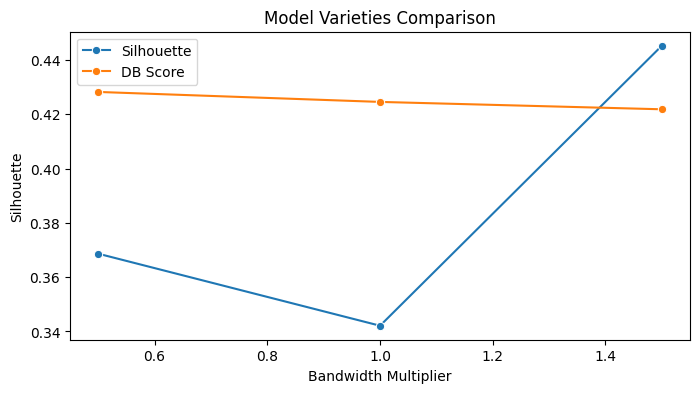

In [7]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=scores_df, x='Bandwidth Multiplier', y='Silhouette', marker='o', label='Silhouette')
sns.lineplot(data=scores_df, x='Bandwidth Multiplier', y='DB Score', marker='o', label='DB Score')
plt.title('Model Varieties Comparison')
plt.show()

In [8]:
best_idx = scores_df['Silhouette'].idxmax()
df['Cluster'] = labels_list[best_idx]
print(df.groupby('Cluster')[['R', 'F', 'M']].mean())

                  R           F              M
Cluster                                       
0        132.985268    6.619226    2086.227369
1          5.526316   58.473684   24655.215789
2         12.250000  101.750000   34393.743000
3          9.500000  115.500000   26713.155000
4         43.500000   47.750000   32711.286375
5         15.000000   23.666667   50396.150000
6        574.483333    4.225000    2705.586508
7          2.000000  114.000000   16353.675000
8          0.500000  209.500000   69369.200000
9         42.561644   38.821918   13737.629178
10       372.000000  151.000000   51078.820000
11         7.600000   76.400000    9440.766000
12         9.000000  155.000000  141991.970000
13         8.000000   82.000000   69795.580000
14         4.000000   17.000000   63591.970000
15         3.000000  143.000000   60911.890000
16         3.000000  124.000000   50683.490000
17         2.000000  198.000000   95392.340000
18         2.000000   61.000000   81846.910000
19         1.

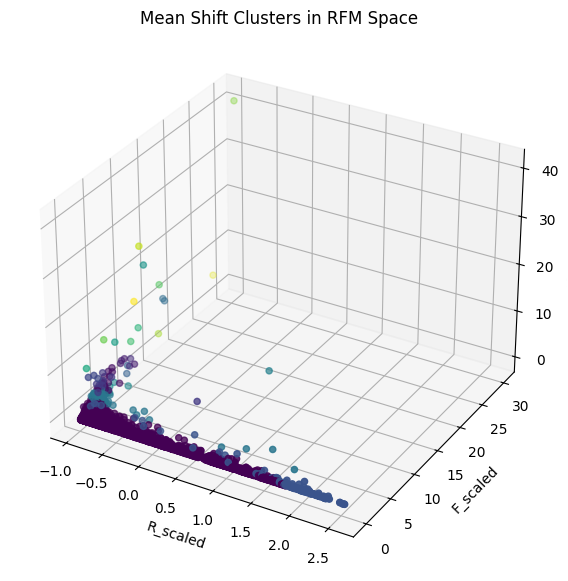

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['R_scaled'], X['F_scaled'], X['M_scaled'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('R_scaled'); ax.set_ylabel('F_scaled'); ax.set_zlabel('M_scaled')
plt.title('Mean Shift Clusters in RFM Space')
plt.show()